In [1]:
import argparse
import torch
import torch.nn as nn
from torchvision import transforms as T
from src.dataset.vanilla_lpcvc import LPCVCDataset
import torchvision

from src.model.model import UNET

from tqdm import tqdm
import random
import numpy as np
import cv2
import PIL

import matplotlib.pyplot as plt
import albumentations as A

from sample_solution.evaluation.accuracy import AccuracyTracker
from matplotlib.colors import ListedColormap
import segmentation_models_pytorch as smp


IMG_SIZE = 256

mean = [0.4607, 0.4558, 0.4192]
std = [0.1855, 0.1707, 0.1769]

colors = ['green', 'red', 'blue', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'pink', 'lime', 'brown', 'gray', 'olive', 'teal', 'navy']
cmap = ListedColormap(colors[:14])


/home/infres/nvernier-22/anaconda3/envs/ml-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=14, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]).to('cuda:0')

In [2]:
model = torch.load('/home/infres/nvernier-22/project/LPCVC-2023/src/model/effnetb0/EFFB0D_260_32_dice_0.611065727005181.pth')

In [5]:

aug_data = A.Compose([
        A.Resize(width=IMG_SIZE, height=IMG_SIZE, interpolation=cv2.INTER_NEAREST),
    ])


train_dataset = LPCVCDataset(datapath='/home/infres/nvernier-22/project/LPCVC-2023/dataset/',transform=aug_data, n_class=14, train=True)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)




In [ ]:
running_mean = 0
for i in range(len(train_dataset)):
    img, _ = train_dataset[i]
    img = np.array(img[0,:,:])
    running_mean += np.mean(img)
print(running_mean/len(train_dataset))
    

In [7]:
model.load_state_dict(torch.load('/home/infres/nvernier-22/project/LPCVC-2023/src/model/unet_mn_4_CYCL/UNET_4_LAYER_MN_CYCLELR_400_32_dice_0.5610295060037741.pth'))

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [6]:
img, label = train_dataset[7]

data = torch.tensor(np.expand_dims(img, axis=0)).to('cuda:0')
print(data.shape)
outputs=model(data)

print(label.shape)

labels = label.reshape(1, 14, IMG_SIZE, IMG_SIZE)
labels = torch.tensor(labels).to('cuda:0')
outputs = torch.tensor(outputs).to('cuda:0')
labels = labels.reshape((1, 14,  IMG_SIZE, IMG_SIZE))

labels = labels.cpu().data.max(1)[1].numpy()
outputs = outputs.cpu().data.max(1)[1].numpy()
labels.astype(np.uint8)
outputs.astype(np.uint8)
labels = np.squeeze(labels, axis=0)
outputs = np.squeeze(outputs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Affichage de la première image
axes[0].imshow(np.transpose(img, (1, 2, 0)))
axes[0].imshow(labels, vmin=0, vmax=13, cmap=cmap, alpha=0.4)

axes[1].imshow(np.transpose(img, (1, 2, 0)))
axes[1].imshow(outputs, vmin=0, vmax=13, cmap=cmap, alpha=0.4)

axes[2].imshow(np.transpose(img, (1, 2, 0)))

print(np.unique(labels))


torch.Size([1, 3, 256, 256])


AttributeError: 'UpsamplingBilinear2d' object has no attribute 'recompute_scale_factor'

NameError: name 'label' is not defined

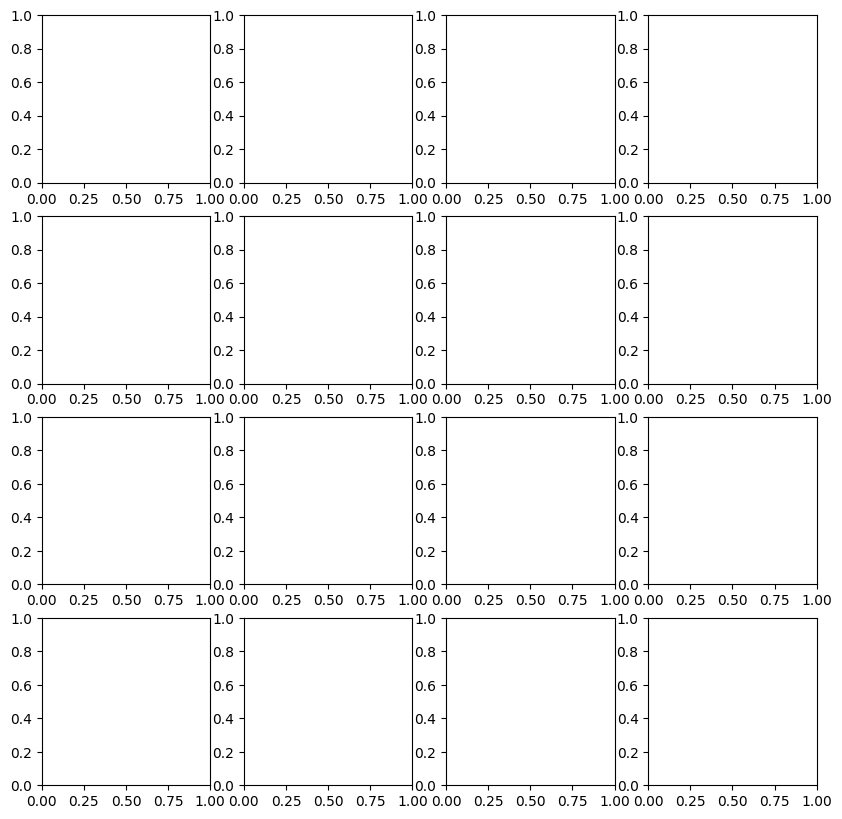

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

# Parcours des images et tracé dans chaque sous-graphique
for i, ax in enumerate(axes.flatten()):
    if i < len(label):
        img = label[i]*(i)
        ax.imshow(img, vmin=0, vmax=13, cmap=cmap)
        ax.axis('off')
    else:
        ax.axis('off')

# Réglage des marges entre les sous-graphiques
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Affichage du graphique
plt.show()

In [ ]:
LEARNING_RATE = 1e-4


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def train(model, criterion, optimizer, scaler, train_loader):
    model.train()
    running_loss=0
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        
        data = data.to(device='cuda:1')
        targets = targets.to(device='cuda:1')        
            
        with torch.cuda.amp.autocast():
            outputs=model(data)
            if(batch_idx == 0):
                output_n = outputs.detach().cpu().numpy()
                target_n = targets.detach().cpu().numpy()
                data_n = data[0].detach().cpu().numpy()

                # output_n = np.argmax(output_n[0], axis=0)
                # output_n[output_n != 0] = -1
                # output_n[output_n == 0] = 1
            
                output_n = np.argmax(output_n[0], axis=0)
                target_n = np.argmax(target_n[0], axis=0)

                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/input'+str(0)+'.png', data_n[0])
                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/predict'+str(0)+'.png', output_n)
                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/target'+str(0)+'.png', target_n)
            loss = criterion(outputs, targets)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())
            
        running_loss += loss.item()

    train_loss=running_loss/len(train_loader)
        
    print('Train Loss: %.3f'%(train_loss))
    return(train_loss)

In [ ]:

def draw(i):
    data, target = train_dataset[0]
    data = torch.tensor(data.reshape((1, 3, 128, 128))).to('cuda:1')
    target = torch.tensor(target.reshape((1, 14, 128, 128))).to('cuda:1')
                   
    output=model(data)

    _, predicted = output.max(1)

    print(predicted.shape)

    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    output = np.argmax(output[0], axis=0)
    plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/predict'+str(i)+'.png', output[ :, :])
    if(i==1):
        plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/target'+str(i)+'.png', target[0, 0, :, :])

In [ ]:
for epoch in range(1, 100):
    print('\nEpoch : %d'%epoch)
    train(model, criterion=criterion, optimizer=optimizer, scaler=scaler, train_loader=train_loader)
    draw(epoch)


In [ ]:
torch.save(model.state_dict(), 'src/model/vanilla-lpcvc_'+str(100)+'.pth')

In [2]:
def get_training_augmentation():
    train_transform = [
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.OneOf(
            [
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
                A.RandomRotate90(p=1),
            ],
            p=0.5,
        ),
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(A.Lambda(image=preprocessing_fn))
    _transform.append(A.Lambda(image=to_tensor, mask=to_tensor))
        
    return A.Compose(_transform)

In [3]:
ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
N_CLASSES = 14
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

In [4]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [5]:
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

In [6]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [2]:
model = torch.load('/home/infres/nvernier-22/project/LPCVC-2023/src/model/fastscnn/NEWNEWFASTSCNN_300_32_dice_0.31061235060985215.pth').to('cuda:0')

In [3]:
transform = T.Compose([T.ToTensor(), T.Resize(size=IMG_SIZE, interpolation=T.functional.InterpolationMode.NEAREST)])
print("Loading dataset...")
val_dataset = LPCVCDataset(datapath="/home/infres/nvernier-22/project/LPCVC-2023/dataset/", n_class=14,mean=mean ,std=std, transform=transform , train=False)
val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        pin_memory=True)

Loading dataset...


In [21]:
image, mask = val_dataset[2]

In [22]:
image = torch.tensor(np.expand_dims(image, axis=0))

In [23]:
output = model(image.to('cuda:0'))

(1, 256, 256)


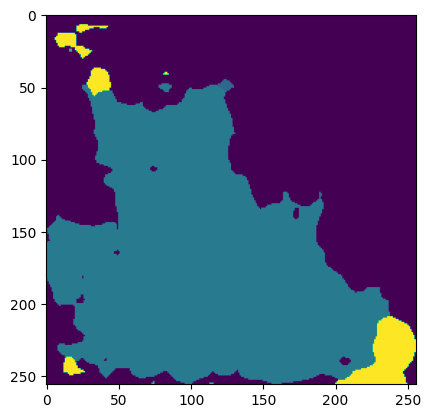

In [24]:
output_vis = output.cpu().data.max(1)[1].numpy()

print(output_vis.shape)
plt.imshow(output_vis[0])

In [27]:
random_idx = random.randint(0, len(valid_dataset)-1)
image, mask = valid_dataset[random_idx]
print(image.shape)
print(mask.shape)

(3, 512, 512)
(14, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


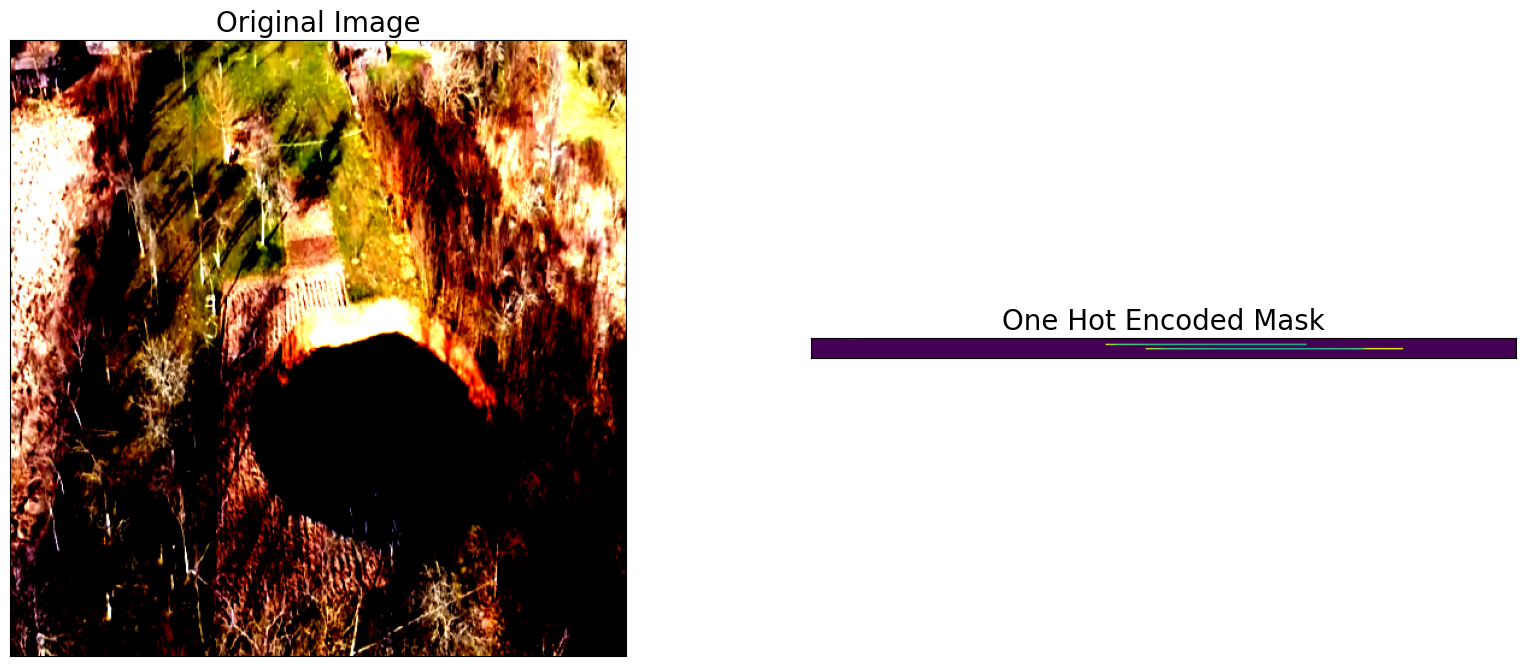

In [28]:
visualize(
    original_image = np.transpose(image, (1, 2, 0)),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([16, 14, 512, 512])


 14%|█▍        | 1/7 [00:02<00:16,  2.81s/it]

torch.Size([16, 14, 512, 512])


 29%|██▊       | 2/7 [00:04<00:10,  2.10s/it]


2
0.2369404210667664


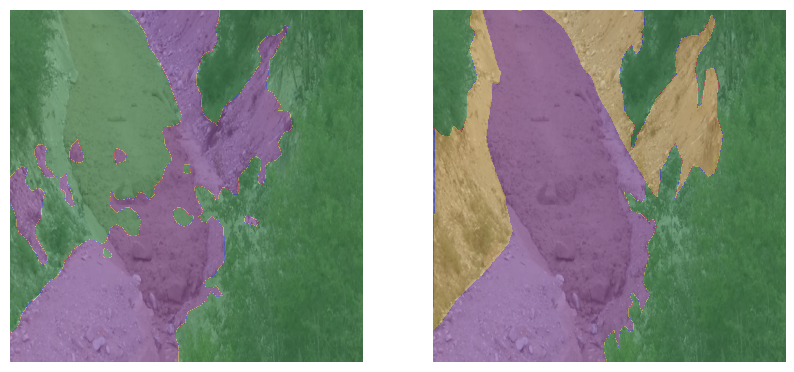

In [35]:

loop = tqdm(valid_loader)

model.eval()
accuracyTracker: AccuracyTracker = AccuracyTracker(n_classes=14)
accuracyTracker.reset()
tot_m_dice = 0
tot = 0
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(loop):
        if(batch_idx > 1):
            break
        tot += 1
        data = data.to(device='cuda:0')
        targets = targets.to(device='cuda:0')

        preds = model(data)

        print(preds.shape)

        preds = preds.cpu().data.max(1)[1].numpy()
        data = data.cpu().numpy()
        targets = targets.cpu().data.max(1)[1].numpy()
        preds.astype(np.uint8)
        targets.astype(np.uint8)

        if(batch_idx%2==0):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            # Tracé de la première image
            axes[0].imshow(np.transpose(data[0]*0.13+0.5, (1, 2, 0)))
            axes[0].imshow(preds[0], cmap=cmap, vmin=0, vmax=13, alpha=0.3)
            axes[0].axis('off')

            # Tracé de la deuxième image
            axes[1].imshow(np.transpose(data[0]*0.13+0.5, (1, 2, 0)))
            axes[1].imshow(targets[0], cmap=cmap, vmin=0, vmax=13, alpha=0.3)
            axes[1].axis('off')

        accuracyTracker.update(targets, preds)
print(tot)
print(accuracyTracker.get_mean_dice())

In [15]:
import torch

In [19]:
from src.model.fast_scnn import FastSCNN

In [32]:

model = FastSCNN(nclass=14)
torch.save(model, '/home/infres/nvernier-22/project/LPCVC-2023/src/model/fastscnn/tes2') 

In [31]:
model.load_state_dict(torch.load('/home/infres/nvernier-22/project/LPCVC-2023/src/model/fastscnn/tes'))

<All keys matched successfully>

In [17]:
torch.save(model, '/home/infres/nvernier-22/project/LPCVC-2023/test')

In [14]:
!nvidia-smi

Mon Jun 26 11:02:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   59C    P0   185W / 250W |   6445MiB / 16384MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   